### Dependencies

In [0]:
from google.colab import drive, files
import numpy as np
from sklearn.metrics import classification_report
from skimage import transform
from PIL import Image
import random
from datetime import datetime

## Data IO

In [3]:
_ = drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# replace with the path of the dataset on your Google Drive
GDRIVE_DATA_DIR = '/content/drive/My Drive/dl-group-spring-20'
ROOT = f'{GDRIVE_DATA_DIR}/pose_dataset/dataset'

In [5]:
%cd $GDRIVE_DATA_DIR
%pwd

/content/drive/My Drive/dl-group-spring-20


'/content/drive/My Drive/dl-group-spring-20'

In [0]:
# TODO: change to import
import os

class DatasetCreator:

    def __init__(self, root, disallowed=['.DS_Store', '']):
        self.root = root
        self.disallowed = disallowed

    @staticmethod
    def _is_image_file(f_name):
        return f_name.endswith('.png') or f_name.endswith('.jpeg') or f_name.endswith('.jpg')

    def get_image_files(self, n=None):
        self.all_image_files = {}
        self.categorical_mapping = {}
        self.n_samples = 0
        for path, _, files in os.walk(self.root):
            label = path.split('/')[-1]
            for f in files:
                if self._is_image_file(f):
                    self.all_image_files[label] = self.all_image_files.get(label, []) + [os.path.join(path, f)]
        if n is None:
            
            for label, file_list in self.all_image_files.items():
                # update categorical mapping
                self.categorical_mapping[label] = len(self.categorical_mapping)
                # update total sample count
                self.n_samples += len(file_list)
            
            return self.n_samples, self.all_image_files
        else:
            image_files = {}
            top_n_labels = [ t[0] for t in sorted([(k, len(v)) for k,v in self.all_image_files.items()], key=lambda x: -x[1])[:n]]
            for label in top_n_labels:
                image_files[label] = self.all_image_files[label]
                self.categorical_mapping[label] = len(self.categorical_mapping)
                self.n_samples += len(self.all_image_files[label])
            return self.n_samples, image_files
            
    def get_label(self, mapped):
        assert(isinstance(mapped, int))
        for k, v in self.categorical_mapping.items():
            if mapped == v:
                return k


In [0]:
N_CLASSES = 17

In [0]:
creator = DatasetCreator(ROOT)

In [9]:
# here we only get the N_CLASSES most prevelant classes in the dataset
n_samples, img_files = creator.get_image_files(n=N_CLASSES) 
categorical_label_mapping = creator.categorical_mapping
n_labels = len(categorical_label_mapping)
assert(n_labels == N_CLASSES)
n_labels, n_samples

(17, 1298)

In [10]:
im_shape = (128,128,3)

X = np.zeros(shape=(tuple([n_samples] + list(im_shape))))
y = np.zeros(shape=n_samples)
idx = 0
for label, files in img_files.items():
    for f in files:
        img = np.asarray(Image.open(f))    
        X[idx,:,:,:] = transform.resize(img, im_shape)
        y[idx] = categorical_label_mapping[label]
        idx += 1
        if (idx % 100) == 0:
          print(f'Finished loading sample {idx}')

Finished loading sample 100
Finished loading sample 200
Finished loading sample 300
Finished loading sample 400
Finished loading sample 500
Finished loading sample 600
Finished loading sample 700
Finished loading sample 800
Finished loading sample 900
Finished loading sample 1000
Finished loading sample 1100
Finished loading sample 1200


In [11]:
X.shape, y.shape

((1298, 128, 128, 3), (1298,))

## EDA

label: adho mukha svanasana


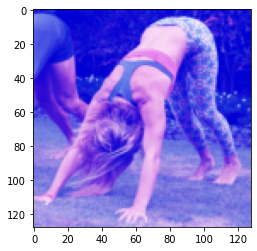

In [12]:
import matplotlib.pyplot as plt

print(f'label: {creator.get_label(int(y[-1]))}')
_ = plt.imshow(X[-1,:,:,:])

## Training

In [0]:
SEED = 42

In [14]:
import tensorflow as tf
tf.__version__

'2.2.0'

### Dataset Partitioning

In [0]:
from sklearn.model_selection import train_test_split

TEST_SET_SIZE = .2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SET_SIZE, random_state=SEED)

In [0]:
VALIDATION_SET_SIZE = 0.2

train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    validation_split=VALIDATION_SET_SIZE
)

train_gen.fit(X_train)

## Transfer Learning
Follows the discussion [here](https://www.tensorflow.org/tutorials/images/transfer_learning). A list of available models is in the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/applications).

> One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

We want to use the feature representations (which are much richer than what we could generate from our small training set here), but optimize for our specific classification task. So, by setting `include_top` to `False` for the models we can attach a bunch of `tf.keras.layers.Dense` layers to the convolutional layers below. 

The higher (later) convolutional layers in these networks learn more specific feature mappings, whereas the initial ones are more responsible for general image feature mapping. So we can make layers on the backend of these models trainable as well.

**Note:** There are two steps here:
1. One should first train the fully connected top with _all_ the pre-trained model's layers set as non-trainable.
2. Then, we can turn those layers into trainable ones and proceed.

In [0]:
tf.keras.backend.clear_session()

In [0]:
def generate_tl_network(
    dense_layer_nodes,
    n_labels,
    pretrained_model,
    dropout_ratio=0.1
):  
    model = tf.keras.Sequential()
    model.add(pretrained_model)
    model.add(tf.keras.layers.Flatten())
    
    for n_nodes in dense_layer_nodes:
        model.add(tf.keras.layers.Dense(n_nodes, activation='relu'))
        model.add(tf.keras.layers.Dropout(dropout_ratio))
    
    model.add(tf.keras.layers.Dense(n_labels, activation='softmax'))
    return model

In [0]:
def decay_alpha_tl(epoch):
  DECAY_EPOCH = 100
  if epoch < DECAY_EPOCH:
    return 0.0001
  else:
    return 0.0001 * tf.math.exp(0.1 * (DECAY_EPOCH - epoch))

In [0]:
BATCH_SIZE = 16
EPOCHS = 150

In [0]:
TL_DENSE_NODES = [
    [256, 128, 64],
    [128, 128, 128],
]

**TODO** try `adam` and `sgd` with momentum for optimizers

### VGG
#### VGG16

In [22]:
vgg_base_model = tf.keras.applications.VGG16(include_top=False, input_shape=im_shape)
n_vgg_base_model_layers = len(vgg_base_model.layers)
n_vgg_base_model_layers

58892288/58889256 [==============================] - 1s 0us/step


19

##### Pre-trained model frozen

In [0]:
vgg_base_model.trainable = False

In [24]:
vgg_models, vgg_results = [], []

for i, node_list in enumerate(TL_DENSE_NODES):

    print(f'Setup model with {len(node_list)} layers: {node_list}')
    m = generate_tl_network(node_list, n_labels, vgg_base_model, 0.2)
    m.compile(tf.keras.optimizers.RMSprop(lr=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    vgg_models.append(m)
    
    r = m.fit(
        train_gen.flow(X_train, y_train, batch_size=BATCH_SIZE, subset='training'),
        steps_per_epoch = (X_train.shape[0] * (1 - TEST_SET_SIZE - VALIDATION_SET_SIZE)) // BATCH_SIZE,
        epochs=EPOCHS,
        verbose=0,
        callbacks = [tf.keras.callbacks.LearningRateScheduler(decay_alpha_tl)],
        validation_data=train_gen.flow(X_train, y_train, batch_size=BATCH_SIZE, subset='validation'),
        validation_steps=(X_train.shape[0] * VALIDATION_SET_SIZE) // BATCH_SIZE
    )
    print(f'Finished training model: {i + 1}')
    m.evaluate(X_test, y_test, batch_size=16)
    vgg_results.append(r)

Setup model with 3 layers: [256, 128, 64]
Finished training model: 1
17/17 [==============================] - 0s 26ms/step - loss: 0.7745 - accuracy: 0.7615
Setup model with 3 layers: [128, 128, 128]
Finished training model: 2
17/17 [==============================] - 0s 16ms/step - loss: 0.7781 - accuracy: 0.7615


In [0]:
best_model_idx = 1
best_model_results = vgg_results[best_model_idx] 

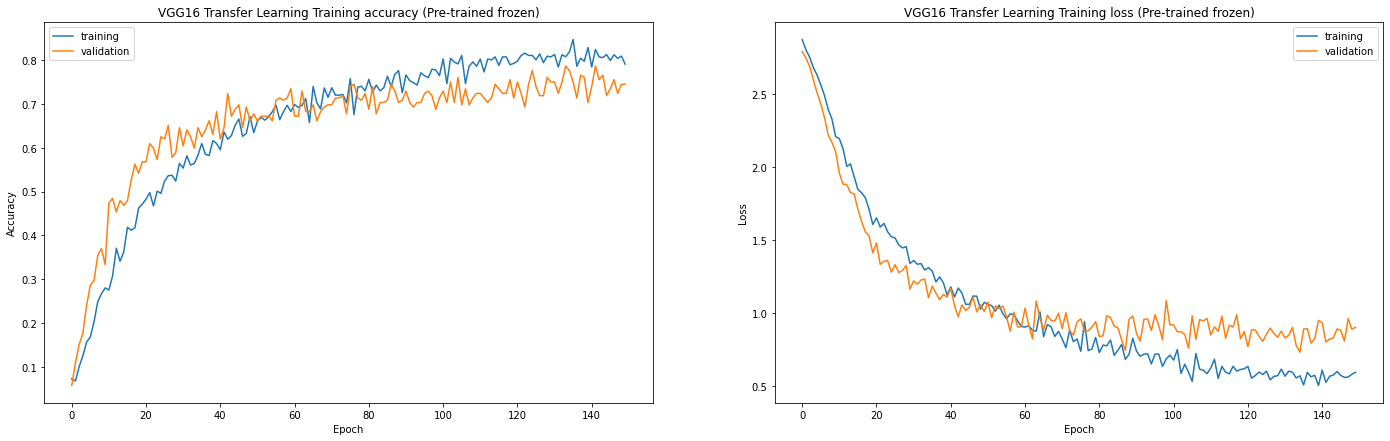

In [26]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(24,7))
ax1.plot(best_model_results.history['accuracy'], label='training')
ax1.plot(best_model_results.history['val_accuracy'], label='validation')
ax1.set_title('VGG16 Transfer Learning Training accuracy (Pre-trained frozen)')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend()
ax2.plot(best_model_results.history['loss'], label='training')
ax2.plot(best_model_results.history['val_loss'], label='validation')
ax2.set_title('VGG16 Transfer Learning Training loss (Pre-trained frozen)')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
_ = ax2.legend()

##### Unfreeze pre-trained model layers
[This](https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a) article is very informative about the pros / cons of fine-tuning.

In [0]:
VGG_FINE_TUNE_LAYERS = 1 # Try [1,2] (the other idea is maybe we have to iteratively walk back 1 -> 2 -> 3)
VGG_FINE_TUNE_EPOCHS = 25 # Maybe this should be less

In [0]:
vgg_base_model.trainable = True

In [29]:
fine_tuned_vgg_results, fine_tuned_vgg_models = [], []

for i, m in enumerate(vgg_models):
    
    for layer in vgg_base_model.layers[:n_vgg_base_model_layers-VGG_FINE_TUNE_LAYERS]:
      layer.trainable = False
    
    m.compile(tf.keras.optimizers.RMSprop(lr=0.0001 / 10), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    print(f'Compiled model {i+1} by unfreezing last: {VGG_FINE_TUNE_LAYERS} layers of VGG16.')
    fine_tuned_vgg_models.append(m)
    r = m.fit(
        train_gen.flow(X_train, y_train, batch_size=BATCH_SIZE, subset='training'),
        steps_per_epoch = (X_train.shape[0] * (1 - TEST_SET_SIZE - VALIDATION_SET_SIZE)) // BATCH_SIZE,
        epochs=VGG_FINE_TUNE_EPOCHS,
        verbose=0,
        callbacks = [tf.keras.callbacks.LearningRateScheduler(decay_alpha_tl)],
        validation_data=train_gen.flow(X_train, y_train, batch_size=BATCH_SIZE, subset='validation'),
        validation_steps=(X_train.shape[0] * VALIDATION_SET_SIZE) // BATCH_SIZE
    )
    m.evaluate(X_test, y_test, batch_size=16)
    fine_tuned_vgg_results.append(r)

Compiled model 1 by unfreezing last: 1 layers of VGG16.
17/17 [==============================] - 0s 16ms/step - loss: 0.7634 - accuracy: 0.7654
Compiled model 2 by unfreezing last: 1 layers of VGG16.
17/17 [==============================] - 0s 16ms/step - loss: 0.8299 - accuracy: 0.7462


In [0]:
best_vgg_model_idx = 0
final_vgg_model = fine_tuned_vgg_models[best_vgg_model_idx]

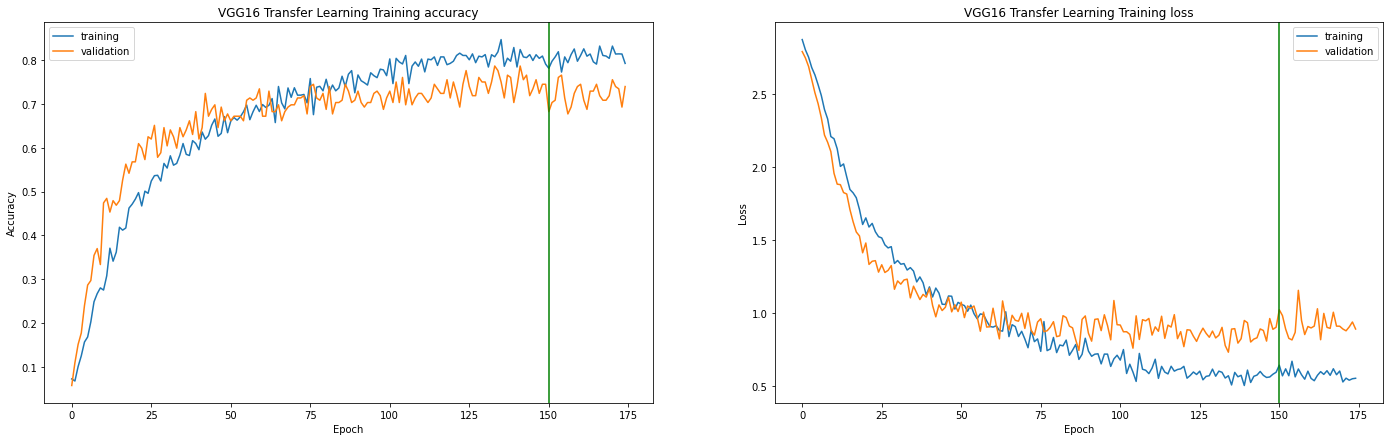

In [35]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(24,7))
ax1.plot(best_model_results.history['accuracy'] + fine_tuned_vgg_results[best_vgg_model_idx].history['accuracy'], label='training')
ax1.plot(best_model_results.history['val_accuracy'] + fine_tuned_vgg_results[best_vgg_model_idx].history['val_accuracy'], label='validation')
ax1.set_title('VGG16 Transfer Learning Training accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.axvline(x=EPOCHS, c='green') # can we give this a label too?
ax1.legend()
ax2.plot(best_model_results.history['loss'] + fine_tuned_vgg_results[best_vgg_model_idx].history['loss'], label='training')
ax2.plot(best_model_results.history['val_loss'] + fine_tuned_vgg_results[best_vgg_model_idx].history['val_loss'], label='validation')
ax2.set_title('VGG16 Transfer Learning Training loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.axvline(x=EPOCHS, c='green')
_ = ax2.legend()

##### Serialize

In [53]:
path = f'{GDRIVE_DATA_DIR}/vgg/n_labels={n_labels}/date={datetime.now().strftime("%Y-%m-%d")}/'
final_vgg_model.save(path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/dl-group-spring-20/vgg/n_labels=17/date=2020-05-13/assets


### DenseNet
#### DenseNet121

In [36]:
densenet_121_base_model = tf.keras.applications.DenseNet121(include_top=False, input_shape=im_shape)
n_densenet_base_model_layers = len(densenet_121_base_model.layers)
n_densenet_base_model_layers

29089792/29084464 [==============================] - 1s 0us/step


427

##### Pre-trained model frozen

In [0]:
densenet_121_base_model.trainable = False

In [38]:
densenet_models, densenet_results = [], []

for node_list in TL_DENSE_NODES:

  print(f'Setup model with {len(node_list)} layers: {node_list}')
  m = generate_tl_network(node_list, n_labels, densenet_121_base_model, 0.2)
  m.compile(tf.keras.optimizers.RMSprop(lr=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  densenet_models.append(m)

  r = m.fit(
      train_gen.flow(X_train, y_train, batch_size=BATCH_SIZE, subset='training'),
      steps_per_epoch = (X_train.shape[0] * (1 - TEST_SET_SIZE - VALIDATION_SET_SIZE)) // BATCH_SIZE,
      epochs=EPOCHS,
      verbose=0,
      callbacks = [tf.keras.callbacks.LearningRateScheduler(decay_alpha_tl)],
      validation_data=train_gen.flow(X_train, y_train, batch_size=BATCH_SIZE, subset='validation'),
      validation_steps=(X_train.shape[0] * VALIDATION_SET_SIZE) // BATCH_SIZE
  )
  print(f'Finished training model: {i + 1}')
  m.evaluate(X_test, y_test, batch_size=16)
  densenet_results.append(r)

Setup model with 3 layers: [256, 128, 64]
Finished training model: 2
17/17 [==============================] - 1s 34ms/step - loss: 0.8560 - accuracy: 0.7154
Setup model with 3 layers: [128, 128, 128]
Finished training model: 2
17/17 [==============================] - 0s 18ms/step - loss: 0.9479 - accuracy: 0.6808


In [0]:
best_model_idx = 0
best_model_results = densenet_results[best_model_idx] 

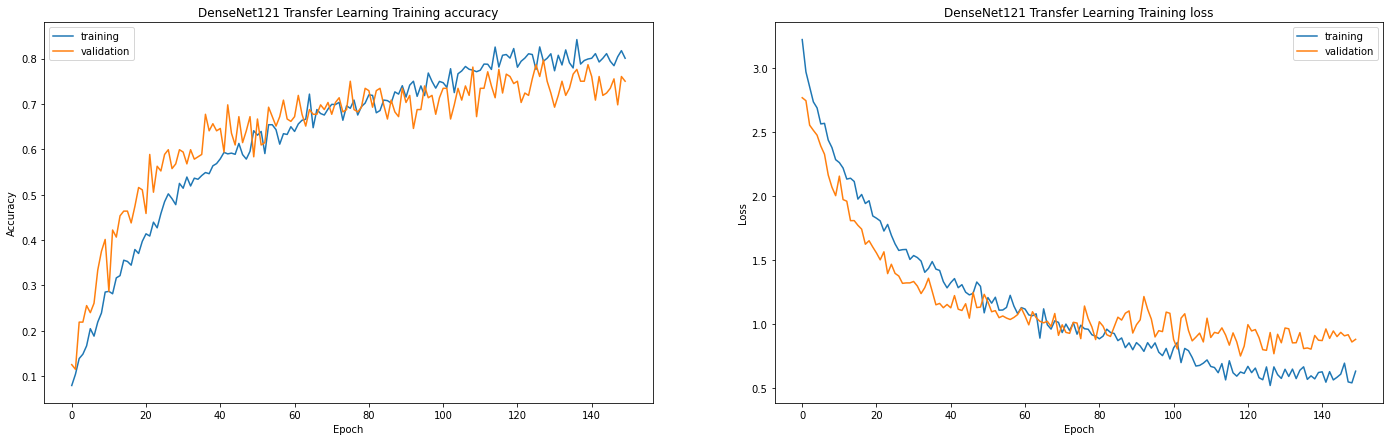

In [40]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(24,7))
ax1.plot(best_model_results.history['accuracy'], label='training')
ax1.plot(best_model_results.history['val_accuracy'], label='validation')
ax1.set_title('DenseNet121 Transfer Learning Training accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend()
ax2.plot(best_model_results.history['loss'], label = 'training')
ax2.plot(best_model_results.history['val_loss'], label='validation')
ax2.set_title('DenseNet121 Transfer Learning Training loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
_ = ax2.legend()

##### Unfreeze pre-trained model layers

In [0]:
densenet_121_base_model.trainable = True

In [0]:
DENSENET_FINE_TUNE_LAYERS = 50
DENSENET_FINE_TUNE_EPOCHS = 50

In [43]:
fine_tuned_densenet_results, fine_tuned_densenet_models = [], []

for i, m in enumerate(densenet_models):
    
    for layer in densenet_121_base_model.layers[:n_densenet_base_model_layers-DENSENET_FINE_TUNE_LAYERS]:
      layer.trainable = False
    
    m.compile(tf.keras.optimizers.RMSprop(lr=0.0001 / 10), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    print(f'Compiled model {i+1} by unfreezing last: {DENSENET_FINE_TUNE_LAYERS} layers of DenseNet121.')
    fine_tuned_densenet_models.append(m)
    r = m.fit(
        train_gen.flow(X_train, y_train, batch_size=BATCH_SIZE, subset='training'),
        steps_per_epoch = (X_train.shape[0] * (1 - TEST_SET_SIZE - VALIDATION_SET_SIZE)) // BATCH_SIZE,
        epochs=DENSENET_FINE_TUNE_EPOCHS,
        verbose=0,
        callbacks = [tf.keras.callbacks.LearningRateScheduler(decay_alpha_tl)],
        validation_data=train_gen.flow(X_train, y_train, batch_size=BATCH_SIZE, subset='validation'),
        validation_steps=(X_train.shape[0] * VALIDATION_SET_SIZE) // BATCH_SIZE
    )
    # print(f'Finished training model: {i + 1}')
    m.evaluate(X_test, y_test, batch_size=16)
    fine_tuned_densenet_results.append(r)

Compiled model 1 by unfreezing last: 50 layers of DenseNet121.
17/17 [==============================] - 0s 18ms/step - loss: 0.8679 - accuracy: 0.7462
Compiled model 2 by unfreezing last: 50 layers of DenseNet121.
17/17 [==============================] - 0s 18ms/step - loss: 0.9473 - accuracy: 0.7462


In [0]:
best_densenet_model_idx = 0
final_densenet_model = fine_tuned_densenet_models[best_densenet_model_idx]

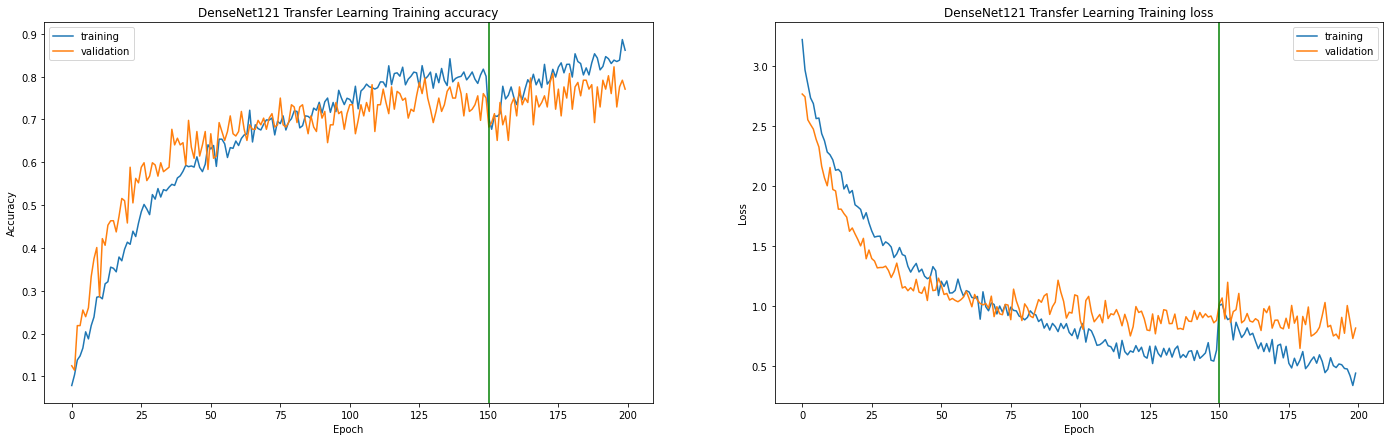

In [48]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(24,7))
ax1.plot(best_model_results.history['accuracy'] + fine_tuned_densenet_results[best_densenet_model_idx].history['accuracy'], label='training')
ax1.plot(best_model_results.history['val_accuracy'] + fine_tuned_densenet_results[best_densenet_model_idx].history['val_accuracy'], label='validation')
ax1.set_title('DenseNet121 Transfer Learning Training accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.axvline(x=EPOCHS, c='green')
ax1.legend()
ax2.plot(best_model_results.history['loss'] + fine_tuned_densenet_results[best_densenet_model_idx].history['loss'], label='training')
ax2.plot(best_model_results.history['val_loss'] + fine_tuned_densenet_results[best_densenet_model_idx].history['val_loss'], label='validation')
ax2.set_title('DenseNet121 Transfer Learning Training loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.axvline(x=EPOCHS, c='green')
_ = ax2.legend()

##### Serialize

In [54]:
path = f'{GDRIVE_DATA_DIR}/densenet/n_labels={n_labels}/date={datetime.now().strftime("%Y-%m-%d")}/'
final_densenet_model.save(path)

INFO:tensorflow:Assets written to: /content/drive/My Drive/dl-group-spring-20/densenet/n_labels=17/date=2020-05-13/assets


#### Evaluation
In order to visualize our aggregate, and class-by-class, loss here we show the `classification_report` provided by the `sklearn` library. This show precision, recall and f1 for the model as a whole along with a label level breakout of each.
##### VGG

In [55]:
y_pred = final_vgg_model.predict_classes(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.80      0.80      0.80        20
         1.0       0.60      0.92      0.73        13
         2.0       0.71      0.77      0.74        22
         3.0       0.61      0.88      0.72        16
         4.0       0.86      0.90      0.88        20
         5.0       0.83      0.83      0.83        12
         6.0       0.90      1.00      0.95        19
         7.0       1.00      0.79      0.88        14
         8.0       1.00      0.72      0.84        18
         9.0       0.62      0.91      0.74        11
        10.0       0.94      0.83      0.88        18
        11.0       0.86      0.75      0.80         8
        12.0       0.78      0.47      0.58        15
        13.0       0.78      0.50      0.61        14
        14.0       0.55      0.50      0.52        12
        15.0       0.30      0.27      0.29        11
        16.0       0.88      0.88      0.88        17

    accuracy              

##### DenseNet

In [56]:
y_pred = final_densenet_model.predict_classes(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.81      0.85      0.83        20
         1.0       1.00      0.69      0.82        13
         2.0       0.56      0.45      0.50        22
         3.0       0.78      0.88      0.82        16
         4.0       0.86      0.95      0.90        20
         5.0       0.90      0.75      0.82        12
         6.0       0.95      0.95      0.95        19
         7.0       1.00      0.79      0.88        14
         8.0       0.73      0.89      0.80        18
         9.0       0.79      1.00      0.88        11
        10.0       0.88      0.78      0.82        18
        11.0       0.89      1.00      0.94         8
        12.0       0.64      0.60      0.62        15
        13.0       1.00      0.71      0.83        14
        14.0       0.71      0.83      0.77        12
        15.0       0.14      0.27      0.19        11
        16.0       1.00      0.71      0.83        17

    accuracy              

## Prediction
Now, training loss and all that jazz is great but these things are really only useful if we can make predictions with them. Here's, how:  

In [0]:
def show_prediction(idx, model):
  true_mapping = int(y_test[idx])
  true_label = creator.get_label(true_mapping) # convert back from np.float
  print(f'ground truth: {true_mapping} -> {true_label}')
  y_pred = model.predict(np.reshape(X_test[idx], tuple([1] + list(X_test[idx].shape)))).argmax()
  pred_label = creator.get_label(int(y_pred))
  print(f'prediction: {int(y_pred)} -> {pred_label}')
  plt.imshow(X_test[idx])
  return

### VGG

ground truth: 8 -> bhujangasana
prediction: 8 -> bhujangasana


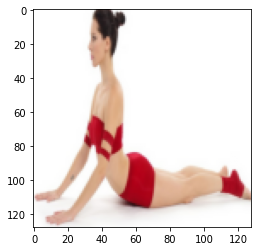

In [58]:
show_prediction(3, final_vgg_model)

ground truth: 8 -> bhujangasana
prediction: 1 -> chaturanga dandasana


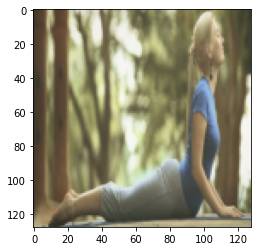

In [59]:
show_prediction(37, final_vgg_model)

ground truth: 13 -> supta baddha konasana
prediction: 13 -> supta baddha konasana


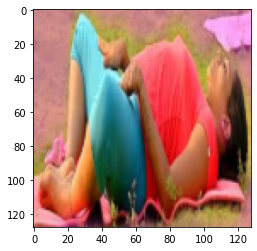

In [60]:
show_prediction(49, final_vgg_model)

ground truth: 16 -> adho mukha svanasana
prediction: 16 -> adho mukha svanasana


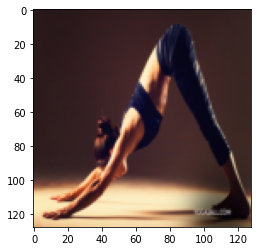

In [61]:
show_prediction(101, final_vgg_model)

### Densenet

ground truth: 15 -> chakravakasana
prediction: 15 -> chakravakasana


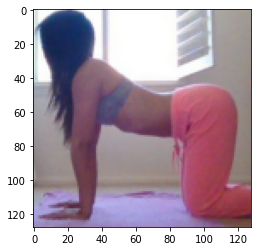

In [62]:
show_prediction(17, final_vgg_model)

ground truth: 3 -> ustrasana
prediction: 3 -> ustrasana


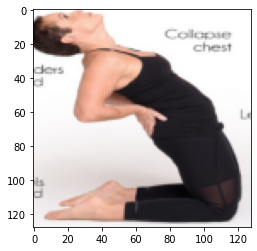

In [63]:
show_prediction(42, final_vgg_model)

ground truth: 10 -> natarajasana
prediction: 10 -> natarajasana


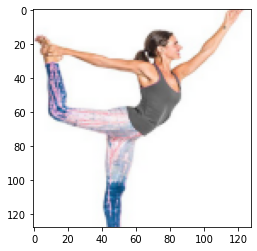

In [64]:
show_prediction(29, final_vgg_model)

ground truth: 4 -> garudasana
prediction: 4 -> garudasana


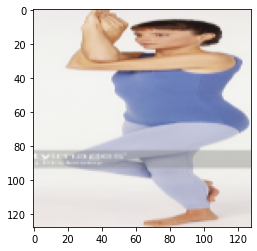

In [65]:
show_prediction(51, final_vgg_model)

ground truth: 10 -> natarajasana
prediction: 10 -> natarajasana


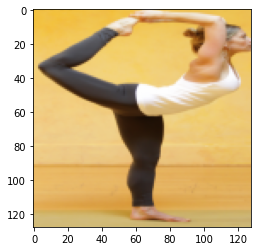

In [66]:
show_prediction(97, final_vgg_model)